# XYZ Sentiment Analysis


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Util functions

In [2]:
import pandas as pd
import pickle
import yaml

def load_data(file_path):
    """
    Load data dari CSV dan filter berdasarkan tahun.
    """
    df = pd.read_csv(file_path)
    df['at'] = pd.to_datetime(df['at'])
    return df[df['at'].dt.year >= 2023]

def save_to_csv(df, file_path):
    """
    Menyimpan DataFrame ke file CSV.
    """
    df.to_csv(file_path, index=False)

def save_model(obj, file_path):
    """
    Menyimpan model atau objek lain menggunakan pickle.
    """
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

def load_model(file_path):
    """
    Memuat model atau objek lain menggunakan pickle.
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

Preprocess Functions

In [3]:
!pip install --quiet Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [4]:
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk import download as nltk_download
from tqdm import tqdm
import pandas as pd
import os

# Download stopwords if not already available
try:
    stopwords.words('indonesian')
except LookupError:
    nltk_download('stopwords')

# Initialize settings for text cleaning
punctuations = set(string.punctuation)
stopwords_indo = set(stopwords.words('indonesian'))
additional_stopwords = ["nya", "nih", "saya", "aja", "aku", "gak", "kalau", "apa", "bri", "knpa", "ceria"]
stopwords_indo.update(additional_stopwords)

stemmer = StemmerFactory().create_stemmer()
url_pattern = re.compile(r'http\S+|www\S+|https\S+', flags=re.MULTILINE)
emoji_pattern = re.compile(r'[^\w\s,]')

def remove_special_characters(text):
    return emoji_pattern.sub('', url_pattern.sub('', text))

def preprocess_text(sentence):
    if isinstance(sentence, str):
        return " ".join([
            stemmer.stem(token) for token in remove_special_characters(sentence).split()
            if token not in stopwords_indo and token not in punctuations
        ])
    return ""

def preprocess_data(df):
    df = df[df['content'].str.split().str.len() >= 3]
    tqdm.pandas()
    df['content_processed'] = df['content'].progress_apply(preprocess_text)
    return df[df.content_processed.notna()]

def remove_specific_words(df):
    df['content_processed'] = df['content_processed'].apply(
        lambda text: " ".join([word for word in text.split() if word not in additional_stopwords])
    )
    return df

# Apply Replacement on Content
def replace_brand_words(text):
    return re.sub(r'\b(bri ceria|ceria|akulaku|atome|kredivo|bri)\b', 'xyz', text, flags=re.IGNORECASE)

ModuleNotFoundError: No module named 'Sastrawi'

### Review Scraping

In [5]:
!pip install --quiet google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00


In [3]:
DATA_PATH = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Review Data"

In [11]:
from google_play_scraper import Sort, reviews_all
import pandas as pd
import os

def get_reviews(app_id, sleep_milliseconds=0, lang='id', country='id', sort=Sort.NEWEST):
    """
    Fetches all reviews for a given Google Play app ID.

    Parameters:
    - app_id (str): Google Play app ID.
    - sleep_milliseconds (int): Delay between requests.
    - lang (str): Language for reviews.
    - country (str): Country code.
    - sort (Sort): Sorting order of reviews.

    Returns:
    - list of dict: A list of reviews for the specified app.
    """
    # Map sort string to Sort enum
    sort_option = Sort.NEWEST if sort.lower() == "newest" else Sort.MOST_RELEVANT
    result = reviews_all(
        app_id,
        sleep_milliseconds=sleep_milliseconds,
        lang=lang,
        country=country,
        sort=sort_option,
    )
    return result

def save_reviews_to_csv(app_id, app_name, output_dir="data/raw", sleep_milliseconds=0, lang='id', country='id', sort="newest"):
    """
    Fetches reviews for a specific app ID and saves them to a CSV file.

    Parameters:
    - app_id (str): Google Play app ID.
    - app_name (str): Name of the app to use in the CSV filename.
    - output_dir (str): Directory to save the CSV file.
    - sleep_milliseconds (int): Delay between requests.
    - lang (str): Language for reviews.
    - country (str): Country code.
    - sort (str): Sorting order of reviews ("newest" or "most_relevant").
    """
    print(f"Fetching reviews for {app_name}...")
    reviews = get_reviews(app_id, sleep_milliseconds=sleep_milliseconds, lang=lang, country=country, sort=sort)
    df = pd.DataFrame(reviews)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save to CSV
    csv_path = os.path.join(output_dir, f"{app_name}.csv")
    df.to_csv(csv_path, index=False)
    print(f"Reviews for {app_name} saved to {csv_path}")

In [ ]:
app_dict = {
    "kredivo": "com.finaccel.android",
    "atome": "id.co.shopintar",
    "akulaku": "io.silvrr.installment",
    "ceria": "id.co.bri.ceria"
}

for app_name, app_id in app_dict.items():
  save_reviews_to_csv(
    app_id=app_id,
    app_name=app_name,
    output_dir=DATA_PATH,
    sleep_milliseconds=30,
    lang='id',
    country='id',
    sort="newest"
  )

### Topic Modelling

In [24]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Gensim based imports
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel

# Define directories
DATA_DIR = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Processed Data"
MODEL_DIR = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Model"

# Vectorization and LDA model creation
def vectorize_text(df):
    """
    Mengubah teks menjadi representasi vektor untuk digunakan dalam LDA.
    """
    vectorizer = CountVectorizer(lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
    return vectorizer, vectorizer.fit_transform(df["content_processed"])

def create_lda_model(data_vectorized, num_topics=5):
    """
    Membuat model LDA berdasarkan data vektor dan jumlah topik yang diinginkan.
    """
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=99, max_iter=30, learning_method='online')
    return lda

def get_coherence_score(model, df_):
    topics = model.components_

    n_top_words = 10
    texts = [[word for word in doc.split()] for doc in df_]

    # create the dictionary
    dictionary = Dictionary(texts)
    # Create a gensim dictionary from the word count matrix

    # Create a gensim corpus from the word count matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    # Get the top words for each topic from the components_ attribute
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

def get_top_words(model, vectorizer, n_top_words=10):
    """
    Mengambil top words dari setiap topic.
    """
    return pd.DataFrame([
        (idx, vectorizer.get_feature_names_out()[i], topic[i])
        for idx, topic in enumerate(model.components_)
        for i in topic.argsort()[:-n_top_words - 1:-1]
    ], columns=["Topic", "Word", "Weight"])

# Main function to run the topic modeling process
def run_topic_modeling(input_file):
    """
    Pipeline utama untuk melakukan topic modeling:
    - Memuat dan memproses data
    - Melakukan vektorisasi
    - Membuat model LDA
    - Menyimpan hasil topik dan model
    """
    # Load and preprocess data
    df = load_data(input_file)
    df = preprocess_data(df)
    df = remove_specific_words(df)

    # Vectorize and create LDA model
    vectorizer, data_vectorized = vectorize_text(df)

    # Finding optimal number of topics
    coherence_scores = {}
    for num_topics in range(2, 15):
        # Latent Dirichlet Allocation Model
        lda = create_lda_model(data_vectorized, num_topics)
        data_lda = lda.fit_transform(data_vectorized)
        score = get_coherence_score(lda, df.content_processed)
        coherence_scores[num_topics] = score

    num_optimal_topics =  max(coherence_scores, key=coherence_scores.get)
    print("Optimal Topics: {}".format(num_optimal_topics))
    lda = create_lda_model(data_vectorized, num_optimal_topics)
    lda.fit_transform(data_vectorized)

    # Extract top words and save them
    top_words_df = get_top_words(lda, vectorizer)
    top_words_path = os.path.join(DATA_DIR, 'top_words_df.csv')
    save_to_csv(top_words_df, top_words_path)

    # Save LDA model and vectorizer
    save_model(lda, os.path.join(MODEL_DIR, 'lda_model.pkl'))
    save_model(vectorizer, os.path.join(MODEL_DIR, 'lda_vectorizer_model.pkl'))
    print(f"LDA model, vectorizer, and top words DataFrame saved successfully at {top_words_path}!")

In [ ]:
run_topic_modeling(input_file=os.path.join(DATA_PATH, 'ceria.csv'))

### Oversampling

In [35]:
import os
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from sklearn.model_selection import train_test_split

# Define paths based on your local folder structure
RAW_DATA_PATH = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Review Data"
PROCESSED_DATA_PATH = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Processed Data"
MODEL_SAVE_PATH = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Model"

# Downsample
def downsample_if_needed(df, max_rows=200000):
    if len(df) > max_rows:
        df = df.sample(n=max_rows, random_state=1)
    return df

def prepare_data(data_frames, label):
    combined_df = downsample_if_needed(pd.concat(data_frames[label], ignore_index=True))
    combined_df['content'] = combined_df['content'].apply(replace_brand_words)
    reviews = combined_df['content'].tolist()
    train_reviews, val_reviews = train_test_split(reviews, test_size=0.1, random_state=42)
    return train_reviews, val_reviews

# Fungsi untuk membuat DataLoader
def create_dataloader(tokenizer, train_reviews, val_reviews):
    train_dataset = ReviewDataset(train_reviews, tokenizer)
    val_dataset = ReviewDataset(val_reviews, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8)
    return train_dataloader, val_dataloader

# GPT-2 Training Dataset Class
class ReviewDataset(Dataset):
    def __init__(self, reviews, tokenizer, max_length=200):
        self.reviews = reviews
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        encoding = self.tokenizer(review, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {key: val.squeeze(0) for key, val in encoding.items()}

def train_model(model, model_name, train_dataloader, val_dataloader, optimizer, device, epochs=5, patience=3, label=None):
    best_val_loss = float('inf')
    patience_counter = 0

    # Set save directory based on label
    model_save_path = os.path.join(MODEL_SAVE_PATH, f"gpt_{label}")
    os.makedirs(model_save_path, exist_ok=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = inputs.clone().to(device)
            outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")

        # Validation Step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                inputs = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = inputs.clone().to(device)
                outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save model to the label-specific folder
            model.save_pretrained(model_save_path)
            tokenizer.save_pretrained(model_save_path)
            print(f"Best model {model_name} saved to {model_save_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

def run_model_training(path_input_list):
    # Mengelompokkan data menjadi positive, neutral, dan negative
    data_frames = {"positive": [], "neutral": [], "negative": []}
    for input_path in path_input_list:
        df = load_data(input_path)
        data_frames["positive"].append(df[df.score > 3])
        data_frames["neutral"].append(df[df.score == 3])
        data_frames["negative"].append(df[df.score < 3])

    # Persiapan data untuk setiap label
    train_reviews = {}
    val_reviews = {}
    for label in ["positive", "neutral", "negative"]:
        train_reviews[label], val_reviews[label] = prepare_data(data_frames, label)

    # Inisialisasi tokenizer dan model GPT-2
    tokenizer = GPT2Tokenizer.from_pretrained('cahya/gpt2-small-indonesian-522M')
    tokenizer.pad_token = tokenizer.eos_token  # Set <eos> as padding token if not defined
    model_base = GPT2LMHeadModel.from_pretrained('cahya/gpt2-small-indonesian-522M')
    model_base.resize_token_embeddings(len(tokenizer))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_base.to(device)

    # Melatih model untuk setiap label dengan early stopping
    for label in ["positive", "neutral", "negative"]:
        print(f"\nStarting training for {label} reviews...")

        # Buat DataLoader untuk setiap label
        train_dataloader, val_dataloader = create_dataloader(tokenizer, train_reviews[label], val_reviews[label])

        # Salin model untuk setiap kelas sentimen
        model = model_base.__class__.from_pretrained('cahya/gpt2-small-indonesian-522M')
        model.resize_token_embeddings(len(tokenizer))
        model.to(device)

        # Optimizer
        optimizer = AdamW(model.parameters(), lr=1e-5)

        # Jalankan pelatihan
        train_model(
            model, f"GPT2_best_model_{label}",
            train_dataloader,
            val_dataloader,
            optimizer,
            device,
            label=label  # Tambahkan label untuk path folder
        )


In [ ]:
input_path_list = [os.path.join(DATA_PATH, file) for file in os.listdir(DATA_PATH) if file.endswith('.csv')]
run_model_training(input_path_list)

### Generate Synthetic Reviews

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import random
import re
import pandas as pd

# Fungsi untuk memuat model berdasarkan kategori input
def load_model(model_type):
    model_paths = {
        'positive': "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Model/gpt_positive",
        'negative': "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Model/gpt_negative",
        'neutral': "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Model/gpt_neutral"
    }

    if model_type not in model_paths:
        raise ValueError("Model type must be 'positive', 'negative', or 'neutral'")

    model_path = model_paths[model_type]

    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    model = GPT2LMHeadModel.from_pretrained(model_path)
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    return tokenizer, model, device

# Fungsi untuk generate banyak review dalam satu batch
def generate_batch_reviews(model_type, prompts, num_return_sequences=1):
    tokenizer, model, device = load_model(model_type)
    inputs = tokenizer(prompts, return_tensors='pt', padding=True).to(device)

    max_length = random.randint(50, 200)

    outputs = model.generate(
        inputs['input_ids'],
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_k=30,
        top_p=0.7,
        temperature=0.8
    )

    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Daftar prompt untuk setiap topik
prompts = {
    "topic_0": [
        "Penggunaan aplikasi ini untuk mengajukan pinjaman",
        "Proses pengajuan pinjaman dan limit yang diberikan oleh aplikasi",
        "Pengelolaan data pengguna saat mengajukan pinjaman",
        "Bunga yang ditawarkan oleh aplikasi ini",
        "Proses pendaftaran dan pengajuan pinjaman melalui aplikasi ini",
        "Proses pendaftaran",
        "Proses pengajuan",
        "Limit dari aplikasi",
        "Data saya",
        "Bunga aplikasi"
    ],
    "topic_1": [
        "Proses login ke aplikasi menggunakan kode OTP",
        "Pengalaman masuk ke aplikasi ini",
        "Penggunaan kode OTP saat masuk ke aplikasi",
        "Login menggunakan OTP dan kendala yang dialami",
        "Proses masuk aplikasi menggunakan email",
        "Saya login",
        "Kode OTP",
        "Email saya",
        "Masuk ke aplikasi"
    ],
    "topic_2": [
        "Penggunaan fitur pembayaran di aplikasi ini",
        "Pengelolaan tagihan dan saldo di aplikasi",
        "Proses pembayaran tagihan menggunakan saldo di aplikasi",
        "Penggunaan autodebet untuk membayar tagihan",
        "Proses pembayaran tagihan secara autodebet di aplikasi ini",
        "Tagihan saya",
        "Saldo aplikasi",
        "Autodebet aplikasi"
    ]
}

# Fungsi untuk menghasilkan beberapa prompt acak sekaligus
def generate_random_prompts(topic, num_prompts=10):
    if topic in prompts:
        return random.choices(prompts[topic], k=num_prompts)
    else:
        return ["Topik tidak ditemukan. Silakan pilih topik yang valid."] * num_prompts

# Fungsi untuk replace kata sekaligus dalam batch teks
def batch_replace_words(texts):
    return [re.sub(r'\b(bri ceria|ceria|akulaku|atome|kredivo|bri)\b', 'xyz', text, flags=re.IGNORECASE) for text in texts]

# Fungsi untuk clean teks sekaligus dalam batch teks
def batch_clean_text(texts):
    pattern = r'[^a-zA-Z0-9.,!?\'" ]'
    return [re.sub(r'\s+', ' ', re.sub(pattern, '', text)).strip() for text in texts]

# Fungsi utama untuk generate review dalam batch dan mengembalikan dalam bentuk DataFrame
def textgen(topic="topic_2", model_type="positive", num_reviews=200):
    batch_size = 100
    total_batches = num_reviews // batch_size
    all_reviews = []

    for _ in range(total_batches):
        prompts_batch = generate_random_prompts(topic, batch_size)
        batch_reviews = generate_batch_reviews(model_type, prompts_batch, num_return_sequences=1)
        cleaned_reviews = batch_clean_text(batch_replace_words(batch_reviews))
        all_reviews.extend(cleaned_reviews)

    remainder = num_reviews % batch_size
    if remainder > 0:
        prompts_batch = generate_random_prompts(topic, remainder)
        batch_reviews = generate_batch_reviews(model_type, prompts_batch, num_return_sequences=1)
        cleaned_reviews = batch_clean_text(batch_replace_words(batch_reviews))
        all_reviews.extend(cleaned_reviews)

    # Mengembalikan hasil review dalam bentuk pandas DataFrame
    df_reviews = pd.DataFrame(all_reviews, columns=["Review"])
    return df_reviews

# Function to calculate class counts, max class, and differences
def calculate_class_differences(column):
    counts = column.value_counts()
    max_class = counts.idxmax()
    differences = counts.max() - counts
    return counts, max_class, differences

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Paper Dataset.xlsx", sheet_name="Voting Result")

df_system = df[["Content","System Availability"]]
df_system = df_system.dropna()

df_fullfillment = df[["Content","Fulfillment"]]
df_fullfillment = df_fullfillment.dropna()

df_billing = df[["Content","Billing"]]
df_billing = df_billing.dropna()

system_availability_counts, system_availability_max_class, system_availability_diff = calculate_class_differences(df_system['System Availability'])
fulfillment_counts, fulfillment_max_class, fulfillment_diff = calculate_class_differences(df_fullfillment['Fulfillment'])
billing_counts, billing_max_class, billing_diff = calculate_class_differences(df_billing['Billing'])

fulfillment_neutral = textgen(topic="topic_0", model_type="neutral", num_reviews=int(fulfillment_diff.loc[1]))
fulfillment_negative = textgen(topic="topic_0", model_type="negative", num_reviews=int(fulfillment_diff.loc[2]))
fulfillment_positive = textgen(topic="topic_0", model_type="positive", num_reviews=int(fulfillment_diff.loc[3]))

system_neutral = textgen(topic="topic_1", model_type="neutral", num_reviews=int(system_availability_diff.loc[1]))
system_negative = textgen(topic="topic_1", model_type="negative", num_reviews=int(system_availability_diff.loc[2]))
system_positive = textgen(topic="topic_1", model_type="positive", num_reviews=int(system_availability_diff.loc[3]))

billing_neutral = textgen(topic="topic_2", model_type="neutral", num_reviews=int(billing_diff.loc[1]))
billing_negative = textgen(topic="topic_2", model_type="negative", num_reviews=int(billing_diff.loc[2]))
billing_positive = textgen(topic="topic_2", model_type="positive", num_reviews=int(billing_diff.loc[3]))


In [5]:
import pandas as pd

# Fungsi untuk membuat DataFrame dari hasil textgen dengan sentiment yang diberikan
def create_sentiment_df(reviews, sentiment_value):
    return pd.DataFrame({
        'text': reviews['Review'],
        'sentiment': sentiment_value
    })

# Membuat DataFrames untuk fulfillment, system, dan billing dengan memanfaatkan fungsi di atas
fulfillment_dfs = [
    df[["Content", "Fulfillment"]].rename(columns={"Content": "text", "Fulfillment": "sentiment"}),
    create_sentiment_df(fulfillment_neutral, 1),
    create_sentiment_df(fulfillment_negative, 2),
    create_sentiment_df(fulfillment_positive, 3)
]

system_dfs = [
    df[["Content", "System Availability"]].rename(columns={"Content": "text", "System Availability": "sentiment"}),
    create_sentiment_df(system_neutral, 1),
    create_sentiment_df(system_negative, 2),
    create_sentiment_df(system_positive, 3)
]

billing_dfs = [
    df[["Content", "Billing"]].rename(columns={"Content": "text", "Billing": "sentiment"}),
    create_sentiment_df(billing_neutral, 1),
    create_sentiment_df(billing_negative, 2),
    create_sentiment_df(billing_positive, 3)
]

# Menggabungkan DataFrames masing-masing kategori
fulfillment_df = pd.concat(fulfillment_dfs, ignore_index=True)
system_df = pd.concat(system_dfs, ignore_index=True)
billing_df = pd.concat(billing_dfs, ignore_index=True)

# Menyimpan hasil ke file Excel
output_path = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Processed Data/"
fulfillment_df.to_excel(f"{output_path}fulfillment_df.xlsx", index=False)
system_df.to_excel(f"{output_path}system_df.xlsx", index=False)
billing_df.to_excel(f"{output_path}billing_df.xlsx", index=False)

### Train BERT Oversampled

In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 17
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def prepare_data(df, label_column, mapping_var):
    # Hanya melakukan pemetaan jika kolom `label_column` memiliki tipe bukan integer
    if df[label_column].dtype != 'int64':
        df[label_column] = df[label_column].map(mapping_var)

    # Split data into train, validation, and test sets
    train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df[label_column])
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=SEED, stratify=train_val_df[label_column])

    # Add status column to differentiate train, validation, and test sets
    df['Status'] = 'Test'
    df.loc[train_df.index, 'Status'] = 'Training'
    df.loc[val_df.index, 'Status'] = 'Validation'

    return df, train_df, val_df, test_df

def encode_data(df, tokenizer, content_column, label_column, max_len=256):
    encoded_data = tokenizer.batch_encode_plus(
        df[content_column].values,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    labels = torch.tensor(df[label_column].values)
    return TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

def get_data_loaders(df, content_column, label_column, tokenizer, batch_size=32):
    # Prepare training and validation data loaders
    train_df = df[df['Status'] == 'Training']
    val_df = df[df['Status'] == 'Validation']
    dataset_train = encode_data(train_df, tokenizer, content_column, label_column)
    dataset_val = encode_data(val_df, tokenizer, content_column, label_column)
    dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
    dataloader_val = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)
    return dataloader_train, dataloader_val

def create_optimizer_and_scheduler(model, dataloader_train, learning_rate=1e-5, epochs=5):
    # Configure optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train) * epochs)
    return optimizer, scheduler

def train_model(model, model_name, optimizer, scheduler, dataloader_train, dataloader_val, device, epochs=5, patience=2, label_column='label'):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = f'/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Model/{model_name}.model'

    for epoch in range(1, epochs + 1):
        model.train()
        loss_train_total = 0

        for batch in dataloader_train:
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            loss_train_total += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            model.zero_grad()

        val_loss, predictions, true_vals = evaluate_model(model, dataloader_val, device)
        val_f1 = f1_score_func(predictions, true_vals)
        print(f"Epoch {epoch} | Training Loss: {loss_train_total / len(dataloader_train):.3f} | Validation Loss: {val_loss:.3f} | F1 Score: {val_f1:.3f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

def evaluate_model(model, dataloader, device):
    model.eval()
    loss_total = 0
    predictions, true_vals = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            loss_total += loss.item()
            predictions.append(logits.detach().cpu().numpy())
            true_vals.append(inputs['labels'].cpu().numpy())

    loss_avg = loss_total / len(dataloader)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_avg, predictions, true_vals

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def main_pipeline(df, content_column, label_column, mapping_var, model_name):
    set_seed()
    tokenizer = BertTokenizer.from_pretrained("indolem/indobert-base-uncased", do_lower_case=True)
    df, train_df, val_df, test_df = prepare_data(df, label_column, mapping_var)
    dataloader_train, dataloader_val = get_data_loaders(df, content_column, label_column, tokenizer)

    model = BertForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=len(mapping_var)).to(device)
    optimizer, scheduler = create_optimizer_and_scheduler(model, dataloader_train)

    train_model(model, model_name, optimizer, scheduler, dataloader_train, dataloader_val, device, epochs=10, label_column=label_column)
    print("Training Complete")


In [ ]:
# Mapping variables
mapping_var = {'Negatif': 2, 'Positif': 3, 'Not Relevant': 0, 'Netral': 1}

# Load and preprocess data
df = (
    pd.read_excel('/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Processed Data/system_df.xlsx')
    .dropna(subset=['sentiment'])
    .reset_index(drop=True)
)
df['sentiment'] = df['sentiment'].astype(int)

# Run the main pipeline
main_pipeline(df, "text", "sentiment", mapping_var, "System_BERT_oversampling")

# Load and preprocess data
df = (
    pd.read_excel('/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Processed Data/billing_df.xlsx')
    .dropna(subset=['sentiment'])
    .reset_index(drop=True)
)
df['sentiment'] = df['sentiment'].astype(int)

# Run the main pipeline
main_pipeline(df, "text", "sentiment", mapping_var, "Billing_BERT_oversampling")

Load and preprocess data
df = (
    pd.read_excel('/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Processed Data/fulfillment_df.xlsx')
    .dropna(subset=['sentiment'])
    .reset_index(drop=True)
)
df['sentiment'] = df['sentiment'].astype(int)

# Run the main pipeline
main_pipeline(df, "text", "sentiment", mapping_var, "Fulfillment_BERT_oversampling")

### Train BERT Original

In [2]:
# Mapping variables
mapping_var = {'Negatif': 2, 'Positif': 3, 'Not Relevant': 0, 'Netral': 1}

# Load and preprocess data
df = (
    pd.read_excel("/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Paper Dataset.xlsx", sheet_name="Voting Result")
    .dropna(subset=['Fulfillment'])
    .reset_index(drop=True)
)
df['Fulfillment'] = df['Fulfillment'].astype(int)

# Run the main pipeline
main_pipeline(df, "text", "Fulfillment", mapping_var, "Fulfillment_BERT_original")

# Load and preprocess data
df = (
    pd.read_excel("/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Paper Dataset.xlsx", sheet_name="Voting Result")
    .dropna(subset=['System Availability'])
    .reset_index(drop=True)
)
df['System Availability'] = df['System Availability'].astype(int)

# Run the main pipeline
main_pipeline(df, "text", "System Availability", mapping_var, "System_BERT_original")

# Load and preprocess data
df = (
    pd.read_excel("/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Paper Dataset.xlsx", sheet_name="Voting Result")
    .dropna(subset=['Billing'])
    .reset_index(drop=True)
)
df['Billing'] = df['Billing'].astype(int)

# Run the main pipeline
main_pipeline(df, "text", "Billing", mapping_var, "Billing_BERT_original")

### Test BERT Performance

In [ ]:
import torch
import pandas as pd
import numpy as np
import re
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mapping variables and paths
mapping_var = {'Negatif': 2, 'Positif': 3, 'Not Relevant': 0, 'Netral': 1}
base_path = '/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Model/'

# Model paths
model_paths = {
    'F_ORI': f"{base_path}/Fulfillment_BERT_original.model",
    'S_ORI': f"{base_path}/System_BERT_original.model",
    'B_ORI': f"{base_path}/Billing_BERT_original.model",
    'F_OVR': f"{base_path}/Fulfillment_BERT_oversampling.model",
    'S_OVR': f"{base_path}/System_BERT_oversampling.model",
    'B_OVR': f"{base_path}/Billing_BERT_oversampling.model"
}

# Function to load model with pretrained weights
def load_model(model_path, num_labels):
    model = BertForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=num_labels)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model

# Function to create a tensor dataset for testing
def create_tensor_test(df, content_column, label_column, tokenizer, max_len=256):
    encoded_data_test = tokenizer.batch_encode_plus(
        df[content_column].values,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )
    labels_test = torch.tensor(df[label_column].values)
    dataset_test = TensorDataset(encoded_data_test['input_ids'], encoded_data_test['attention_mask'], labels_test)
    return dataset_test

# Function to evaluate the model
def evaluate(model, dataloader, device):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: value.to(device) for key, value in zip(['input_ids', 'attention_mask', 'labels'], batch)}
            outputs = model(**inputs)
            loss_val_total += outputs.loss.item()

            predictions.append(outputs.logits.detach().cpu().numpy())
            true_vals.append(inputs['labels'].cpu().numpy())

    loss_val_avg = loss_val_total / len(dataloader)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

# Function to compute F1 score and plot confusion matrix
def calculate_metrics_and_plot(predictions, true_vals, mapping_var, label_column):
    preds_flat = np.argmax(predictions, axis=1).flatten()
    true_flat = true_vals.flatten()
    f1 = f1_score(true_flat, preds_flat, average='weighted')

    print(f"F1 Score on Test Set: {f1}")

    cm = confusion_matrix(true_flat, preds_flat)
    labels = list(mapping_var.keys())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {label_column}')
    plt.show()
    return preds_flat, true_flat

# Function to load model, process test data, and evaluate
def load_and_test_model(df, content_column, label_column, model, mapping_var, chart_name):
    tokenizer = BertTokenizer.from_pretrained("indolem/indobert-base-uncased", do_lower_case=True)
    dataset_test = create_tensor_test(df, content_column, label_column, tokenizer)
    dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=32)

    loss_test, predictions, true_vals = evaluate(model, dataloader_test, device)
    print(f"Test Loss: {loss_test}")
    preds_flat, true_flat = calculate_metrics_and_plot(predictions, true_vals, mapping_var, chart_name)
    return preds_flat, true_flat

# Text preprocessing functions
def batch_replace_words(texts):
    return [re.sub(r'\b(bri ceria|ceria|akulaku|atome|kredivo|bri)\b', 'xyz', text, flags=re.IGNORECASE) for text in texts]

def batch_clean_text(texts):
    pattern = r'[^a-zA-Z0-9.,!?\'" ]'
    return [re.sub(r'\s+', ' ', re.sub(pattern, '', text)).strip() for text in texts]

# Load test data
bill_test_data = pd.read_excel("/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Paper Dataset.xlsx", sheet_name="Billing Test Data")
system_test_data = pd.read_excel("/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Paper Dataset.xlsx", sheet_name="System Test Data")
fulfill_test_data = pd.read_excel("/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Paper Dataset.xlsx", sheet_name="Billing Test Data")


In [ ]:
# Load models
models = {name: load_model(path, num_labels=len(mapping_var)) for name, path in model_paths.items()}

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Test Loss: 2.815142571926117
F1 Score on Test Set: 0.13260135135135137


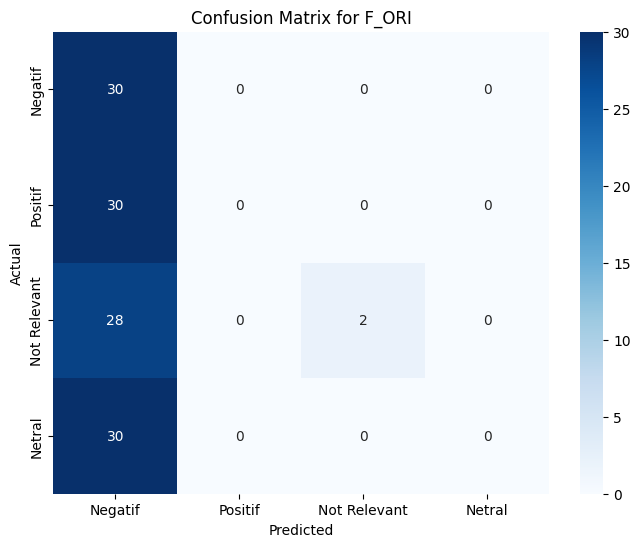

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Test Loss: 1.864928498864174
F1 Score on Test Set: 0.2905590428625184


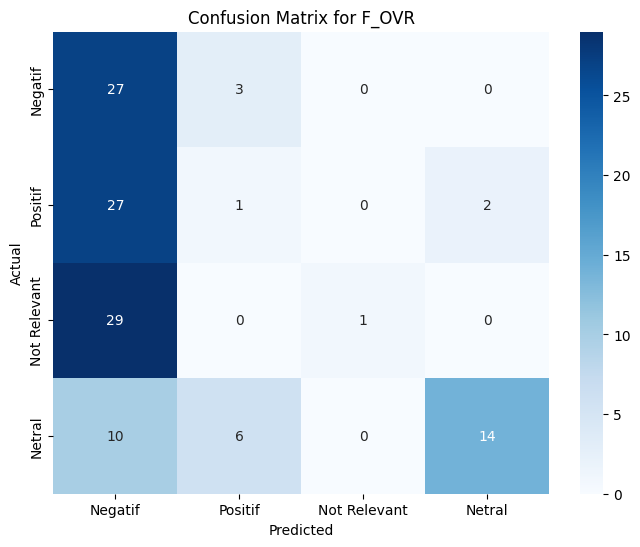

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Test Loss: 2.6020518615841866
F1 Score on Test Set: 0.3103896103896104


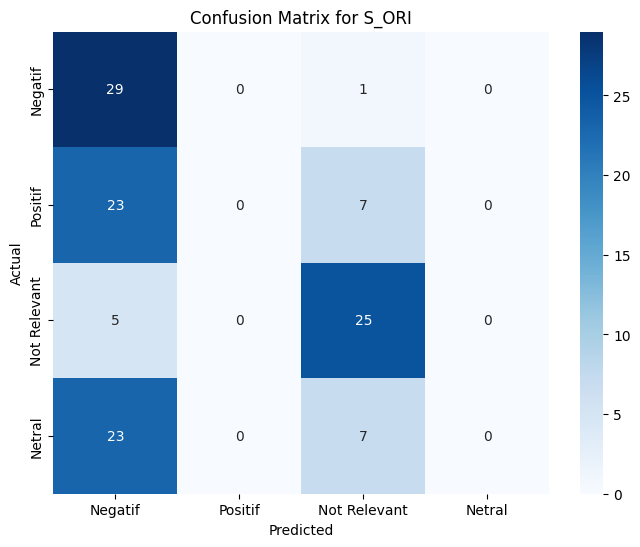

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Test Loss: 1.2179356589913368
F1 Score on Test Set: 0.5781718872035188


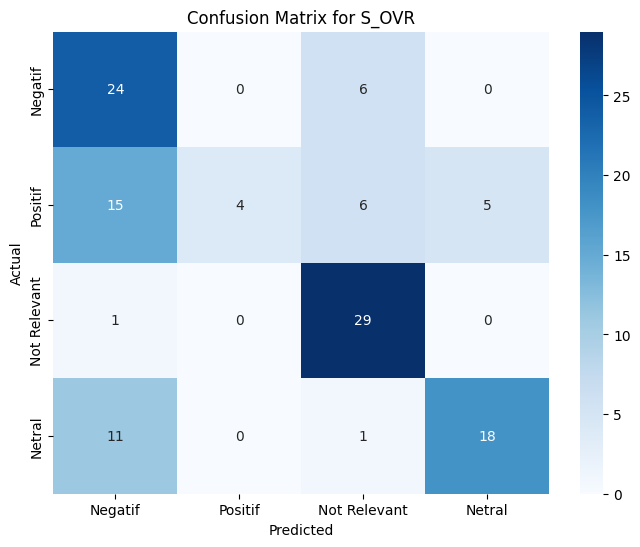

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Test Loss: 1.8008576035499573
F1 Score on Test Set: 0.3112320633349827


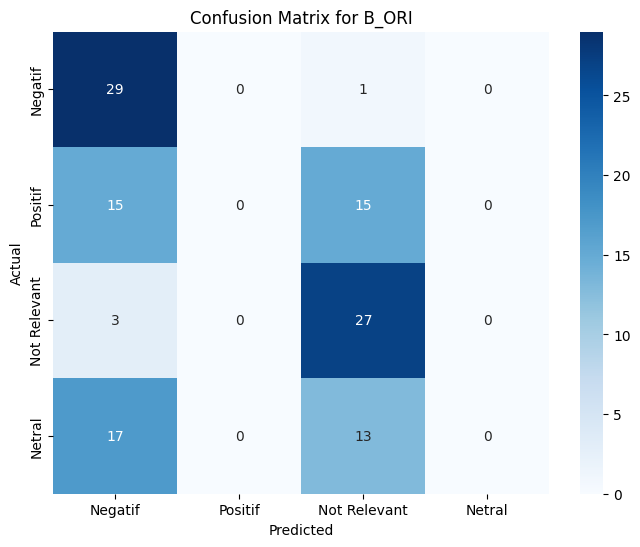

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Test Loss: 1.7801437452435493
F1 Score on Test Set: 0.5344872360334217


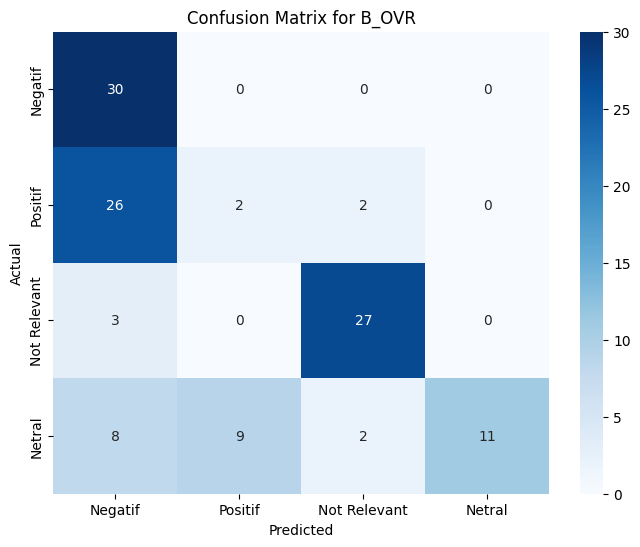

In [5]:
_, __ = load_and_test_model(fulfill_test_data, "content", "sentiment", models['F_ORI'], mapping_var, "F_ORI")
_, __ = load_and_test_model(fulfill_test_data, "content", "sentiment", models['F_OVR'], mapping_var, "F_OVR")
_, __ = load_and_test_model(system_test_data, "content", "sentiment", models['S_ORI'], mapping_var, "S_ORI")
_, __ = load_and_test_model(system_test_data, "content", "sentiment", models['S_OVR'], mapping_var, "S_OVR")
_, __ = load_and_test_model(bill_test_data, "content", "sentiment", models['B_ORI'], mapping_var, "B_ORI")
_, __ = load_and_test_model(bill_test_data, "content", "sentiment", models['B_OVR'], mapping_var, "B_OVR")

### Predict All Reviews

In [2]:
import torch
import os
import pandas as pd
import re
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
from sklearn.metrics import f1_score, confusion_matrix

# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mapping variables and paths
mapping_var = {'Not Relevant': 0, 'Neutral': 1, 'Negative': 2, 'Positive': 3}
base_path = '/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Model/'

# Model paths
model_paths = {
    'F_ORI': f"{base_path}/Fulfillment_BERT_original.model",
    'S_ORI': f"{base_path}/System_BERT_original.model",
    'B_ORI': f"{base_path}/Billing_BERT_original.model",
    'F_OVR': f"{base_path}/Fulfillment_BERT_oversampling.model",
    'S_OVR': f"{base_path}/System_BERT_oversampling.model",
    'B_OVR': f"{base_path}/Billing_BERT_oversampling.model"
}

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("indolem/indobert-base-uncased", do_lower_case=True)

# Function to load a model with pretrained weights
def load_model(model_path, num_labels):
    model = BertForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=num_labels)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load all models into a dictionary
models = {name: load_model(path, num_labels=len(mapping_var)) for name, path in model_paths.items()}

# Text preprocessing functions
def batch_replace_words(texts):
    return [re.sub(r'\b(bri ceria|ceria|akulaku|atome|kredivo|bri)\b', 'xyz', text, flags=re.IGNORECASE) for text in texts]

def batch_clean_text(texts):
    pattern = r'[^a-zA-Z0-9.,!?\'" ]'
    return [re.sub(r'\s+', ' ', re.sub(pattern, '', text)).strip() for text in texts]

# Optimized batch prediction function
def batch_predict(texts, model, tokenizer, mapping_var, device, batch_size=32):
    reverse_mapping_var = {v: k for k, v in mapping_var.items()}
    encoded_data = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=256,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoded_data['input_ids'].to(device)
    attention_masks = encoded_data['attention_mask'].to(device)
    dataset = TensorDataset(input_ids, attention_masks)
    dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            outputs = model(**inputs)
            logits = outputs.logits
            batch_predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
            predictions.extend(batch_predictions)

    # Convert numeric predictions back to labels
    return [reverse_mapping_var[pred] for pred in predictions]

# Load and filter review data
DATA_PATH = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Review Data"
ceria_file_path = os.path.join(DATA_PATH, 'ceria.csv')
df_ceria = pd.read_csv(ceria_file_path)
df_ceria['at'] = pd.to_datetime(df_ceria['at'])
df_ceria = df_ceria[df_ceria['at'].dt.year >= 2023]

# Apply batch predictions
b_result = batch_predict(df_ceria['content'].tolist(), models["B_OVR"], tokenizer, mapping_var, device)
s_result = batch_predict(df_ceria['content'].tolist(), models["S_OVR"], tokenizer, mapping_var, device)
f_result = batch_predict(df_ceria['content'].tolist(), models["F_OVR"], tokenizer, mapping_var, device)

# Menambahkan hasil prediksi ke DataFrame
df_ceria['Billing_Prediction'] = b_result
df_ceria['System_Prediction'] = s_result
df_ceria['Fulfillment_Prediction'] = f_result

# Menyimpan DataFrame ke file CSV
PROCESSED_DATA_PATH = "/content/drive/MyDrive/Irfanda - Folder/Academic/Postgraduate/PI 2024/PeerJ Submission/Processed Data/"
output_path = os.path.join(PROCESSED_DATA_PATH, 'ceria_with_predictions.csv')
df_ceria.to_csv(output_path, index=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-2-86a8c383cf4a>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

<ipython-input-8-3565f5c43038>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=order, palette='viridis')


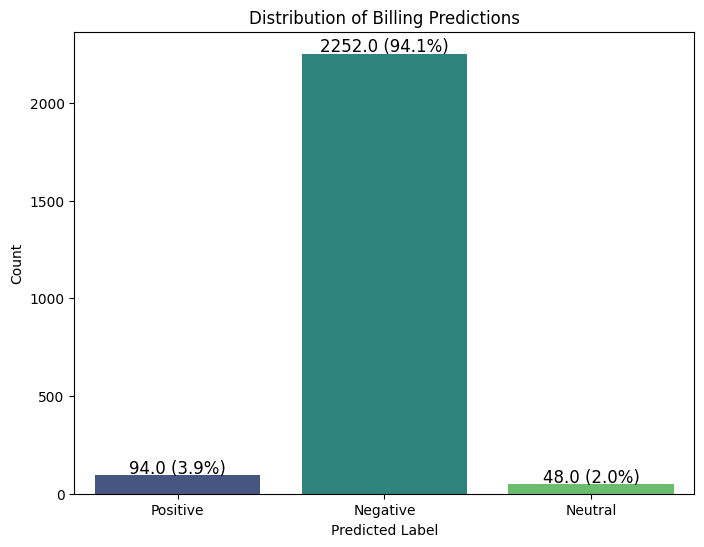

<ipython-input-8-3565f5c43038>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=order, palette='viridis')


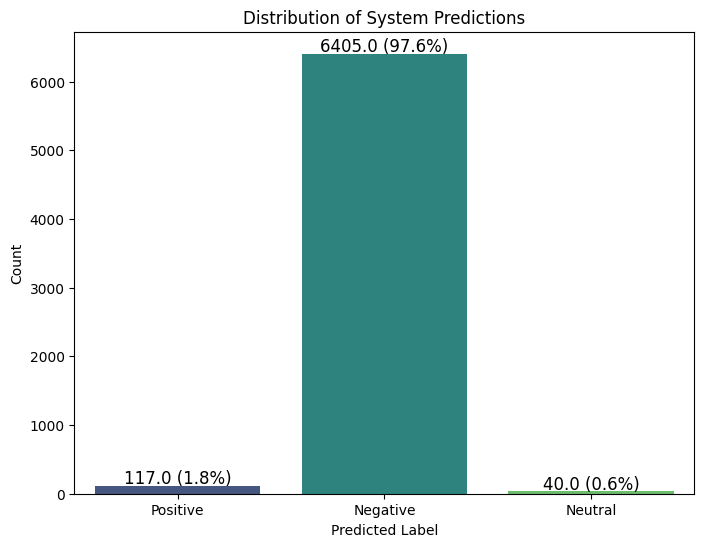

<ipython-input-8-3565f5c43038>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=column, order=order, palette='viridis')


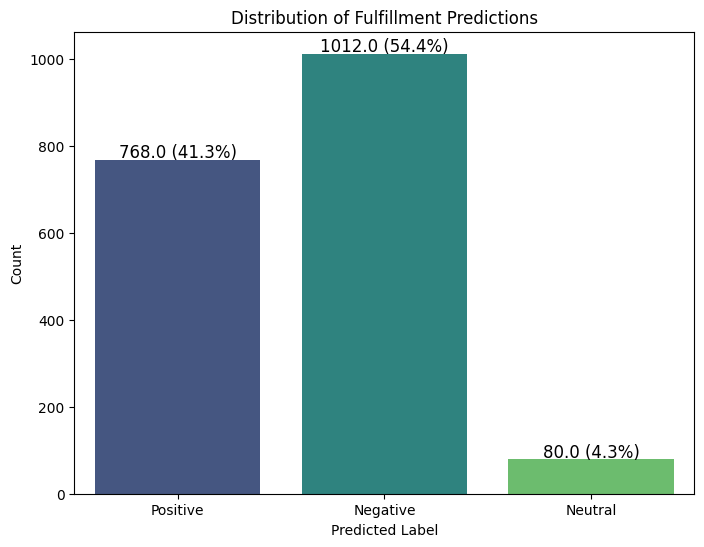

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results = {
    'Billing_Prediction': b_result,
    'System_Prediction': s_result,
    'Fulfillment_Prediction': f_result
}

# Urutan label yang akan ditampilkan, tanpa 'Not Relevant'
order = ['Positive', 'Negative', 'Neutral']

# Fungsi plotting dengan count dan persentase
def plot_ordered_prediction_distribution(data, column, title):
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=data, x=column, order=order, palette='viridis')
    total = len(data[column])
    for p in ax.patches:
        count = p.get_height()
        percentage = f'{100 * count / total:.1f}%'
        ax.annotate(f'{count} ({percentage})',
                    (p.get_x() + p.get_width() / 2., count),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.title(f'Distribution of {title} Predictions')
    plt.xlabel('Predicted Label')
    plt.ylabel('Count')
    plt.show()

for column, result in results.items():
    # Membuat DataFrame dan menghilangkan kelas 'Not Relevant'
    df = pd.DataFrame({column: result})
    df = df[df[column] != 'Not Relevant']

    # Plot distribusi
    plot_ordered_prediction_distribution(df, column, column.replace('_Prediction', ''))
